In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 20 kB/s 
     |████████████████████████████████| 6.6 MB 28.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101

In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 4.0 MB/s 
     |████████████████████████████████| 50 kB 3.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=baf56f928b5edf6add8404bbd592c8be7552167ad4862e7de6ff037ef642e35f
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
Successfully built fvcore


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [ ]:
!curl -L "{https://app.roboflow.com/ds/kJSojC9vwz?key=hCnjaERNyg}" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   879  100   879    0     0   2462      0 --:--:-- --:--:-- --:--:--  2469
100 3606k  100 3606k    0     0  6304k      0 --:--:-- --:--:-- --:--:-- 6304k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/img_12_jpg.rf.710fce802034d961603a10090ad2611f.jpg  
 extracting: test/img_19_jpg.rf.dcf127909e5f84dd365bbde6ea12962d.jpg  
 extracting: test/img_1_jpg.rf.1446ea558a7d3b77f2a0543af5967265.jpg  
 extracting: test/img_24_jpg.rf.4349f1d7976a7d08bcdf6f45937bf561.jpg  
 extracting: test/img_25_jpg.rf.2ce3e777b357502a32d37b30bc5f62c7.jpg  
   creating: train/
 extracting: train/_annotations.coco.json  
 extracting: train/img_10_jpg.rf.15d8d2d00ad628806ef6065cc55e0f6b.jpg  
 extracting: train/img_10_jpg.rf.

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

WARNING [06/06 16:03:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 16:03:59 d2.data.datasets.coco]: Loaded 60 images in COCO format from /content/train/_annotations.coco.json


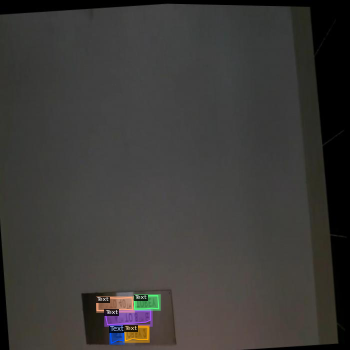

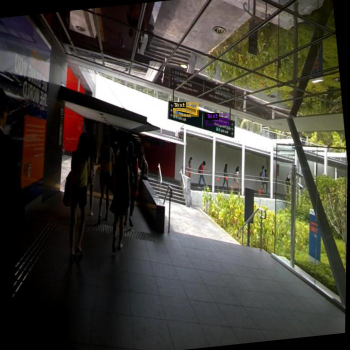

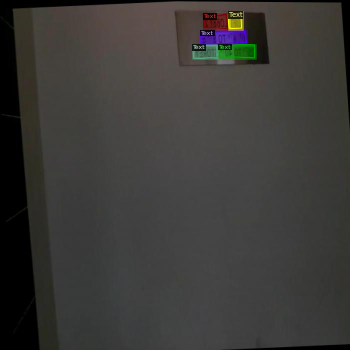

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 15
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 4500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 4500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 96 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 16:04:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 78.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (97, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (97,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (384, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (384,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

[06/06 16:04:15 d2.engine.train_loop]: Starting training from iteration 0
[06/06 16:04:40 d2.utils.events]:  eta: 1:32:56  iter: 19  total_loss: 6.001  loss_cls: 4.517  loss_box_reg: 0.161  loss_mask: 0.696  loss_rpn_cls: 0.525  loss_rpn_loc: 0.046  time: 1.2443  data_time: 0.1677  lr: 0.000020  max_mem: 10664M
[06/06 16:05:05 d2.utils.events]:  eta: 1:32:41  iter: 39  total_loss: 5.383  loss_cls: 4.065  loss_box_reg: 0.164  loss_mask: 0.670  loss_rpn_cls: 0.399  loss_rpn_loc: 0.045  time: 1.2433  data_time: 0.1471  lr: 0.000040  max_mem: 10664M
[06/06 16:05:30 d2.utils.events]:  eta: 1:32:12  iter: 59  total_loss: 4.186  loss_cls: 2.892  loss_box_reg: 0.365  loss_mask: 0.627  loss_rpn_cls: 0.285  loss_rpn_loc: 0.048  time: 1.2407  data_time: 0.1405  lr: 0.000060  max_mem: 10664M
[06/06 16:05:54 d2.utils.events]:  eta: 1:31:49  iter: 79  total_loss: 2.441  loss_cls: 1.042  loss_box_reg: 0.490  loss_mask: 0.582  loss_rpn_cls: 0.194  loss_rpn_loc: 0.045  time: 1.2389  data_time: 0.1430  

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/06 17:37:44 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 17:37:44 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/test/_annotations.coco.json
[06/06 17:37:44 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    Text    | 0            |    Text    | 31           |
|            |              |            |              |
|   total    | 31           |            |              |
[06/06 17:37:44 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[06/06 17:37:44 d2.data.common]: Serialized dataset takes 0.01 MiB
[06/06 17:37:44 d2.evaluation.evaluator]: Start inference on 5 images
[06/06 17:37:44 d2.evaluation.evaluator]: Total inference time: 0:00:00.139488 (0.139488 s / img per device, on 1 devices)
[06/06 17:37:4

OrderedDict([('bbox',
              {'AP': 6.624156377577761,
               'AP-Text': 6.624156377577761,
               'AP50': 23.087687796135235,
               'AP75': 2.5577557755775575,
               'APl': 0.0,
               'APm': 15.702970297029703,
               'APs': 6.870912123547064}),
             ('segm',
              {'AP': 6.872001029890222,
               'AP-Text': 6.872001029890222,
               'AP50': 17.12660627764904,
               'AP75': 3.9603960396039604,
               'APl': 0.0,
               'APm': 15.445544554455445,
               'APs': 6.752828854314004})])

WARNING [06/06 17:37:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 17:37:49 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/test/_annotations.coco.json
[06/06 17:37:49 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[06/06 17:37:49 d2.data.common]: Serialized dataset takes 0.01 MiB
[06/06 17:37:49 d2.evaluation.evaluator]: Start inference on 5 images
[06/06 17:37:50 d2.evaluation.evaluator]: Total inference time: 0:00:00.147222 (0.147222 s / img per device, on 1 devices)
[06/06 17:37:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.065387 s / img per device, on 1 devices)
[06/06 17:37:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 17:37:50 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/06 17:37:50 d2.evaluation.coco_evaluation]: Evaluating predictio

OrderedDict([('bbox',
              {'AP': 6.624156377577761,
               'AP-Text': 6.624156377577761,
               'AP50': 23.087687796135235,
               'AP75': 2.5577557755775575,
               'APl': 0.0,
               'APm': 15.702970297029703,
               'APs': 6.870912123547064}),
             ('segm',
              {'AP': 6.872001029890222,
               'AP-Text': 6.872001029890222,
               'AP50': 17.12660627764904,
               'AP75': 3.9603960396039604,
               'APl': 0.0,
               'APm': 15.445544554455445,
               'APs': 6.752828854314004})])

In [ ]:
%ls ./output/

events.out.tfevents.1654531453.6b18930b390e.85.0  metrics.json
last_checkpoint                                   model_final.pth
coco_instances_results.json                       last_checkpoint
events.out.tfevents.1654531453.6b18930b390e.85.0  metrics.json
instances_predictions.pth                         model_final.pth
coco_instances_results.json                       last_checkpoint
events.out.tfevents.1654531453.6b18930b390e.85.0  metrics.json
instances_predictions.pth                         model_final.pth


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

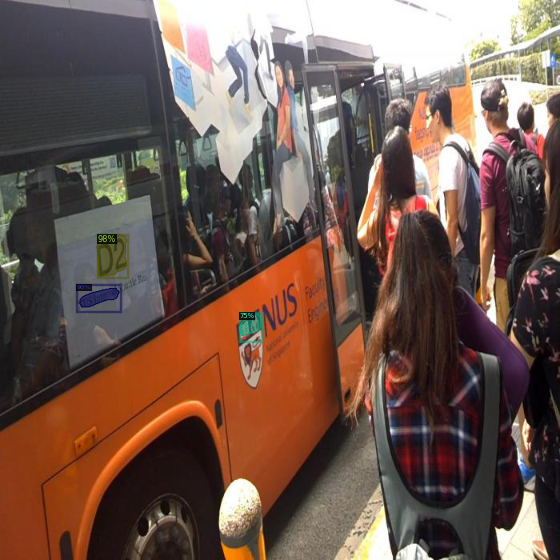

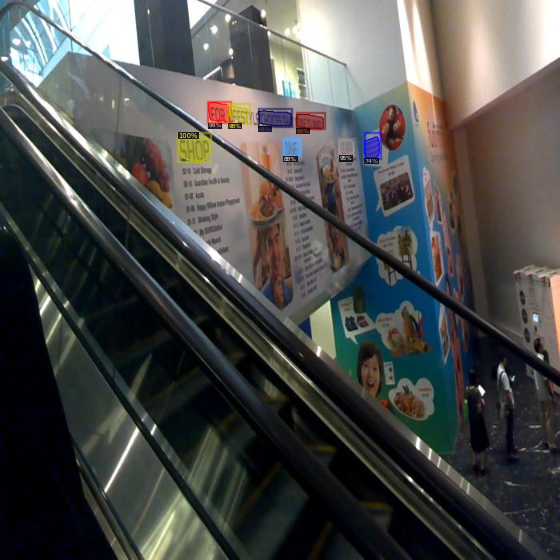

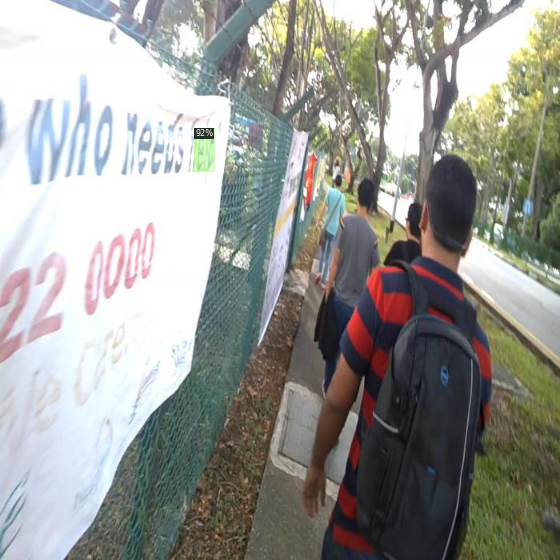

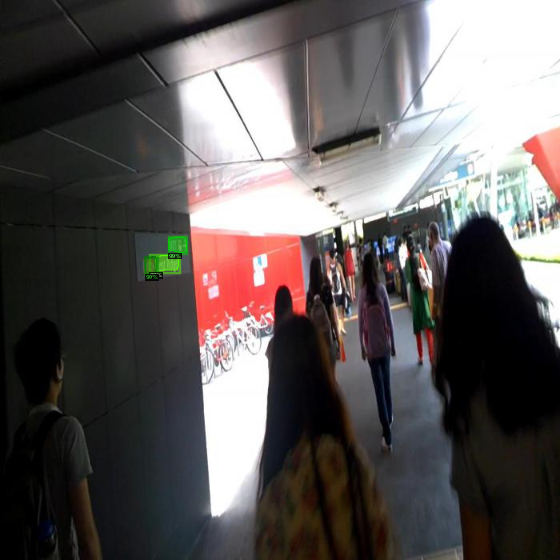

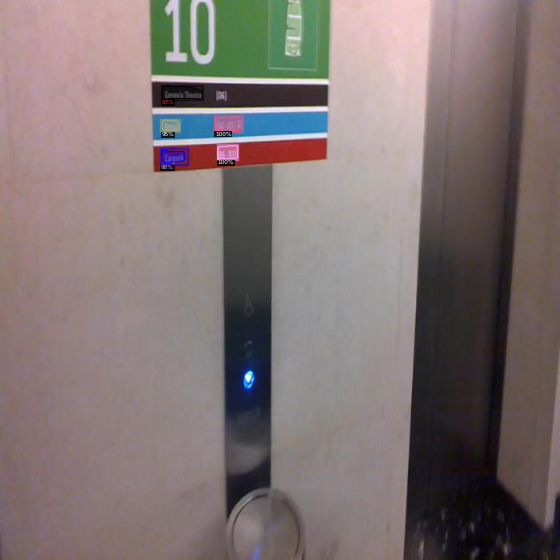

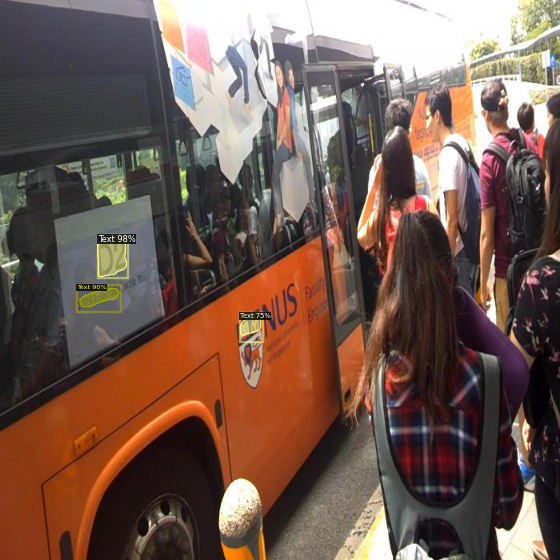

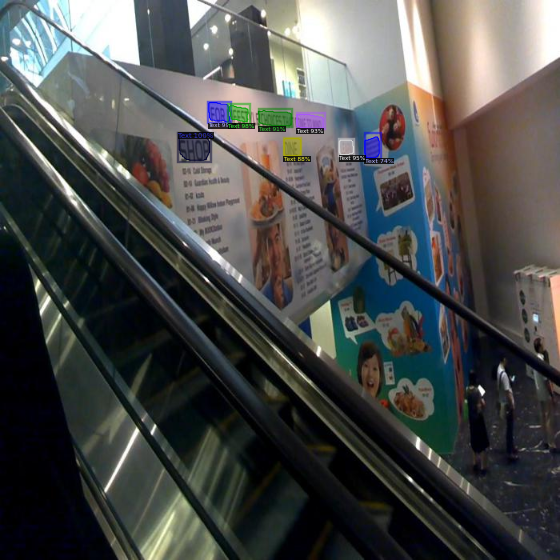

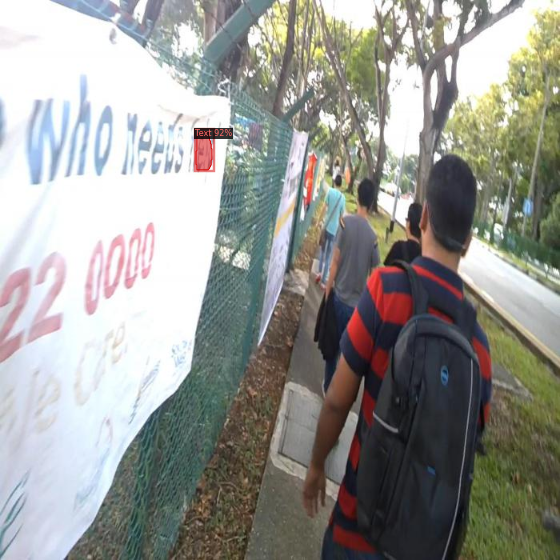

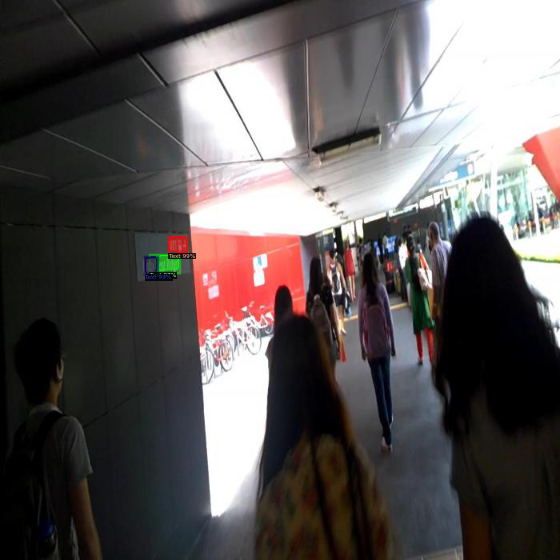

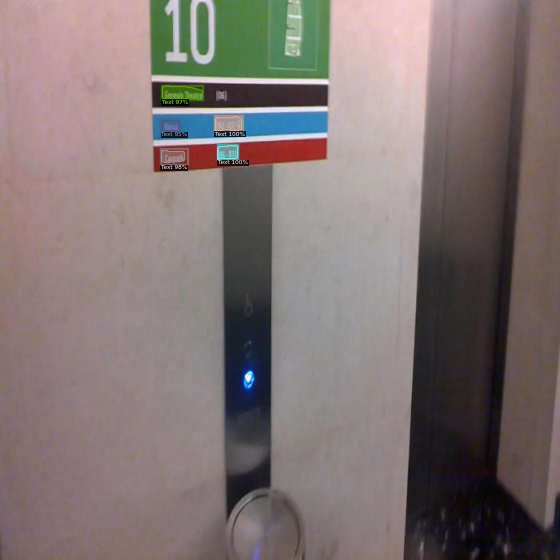

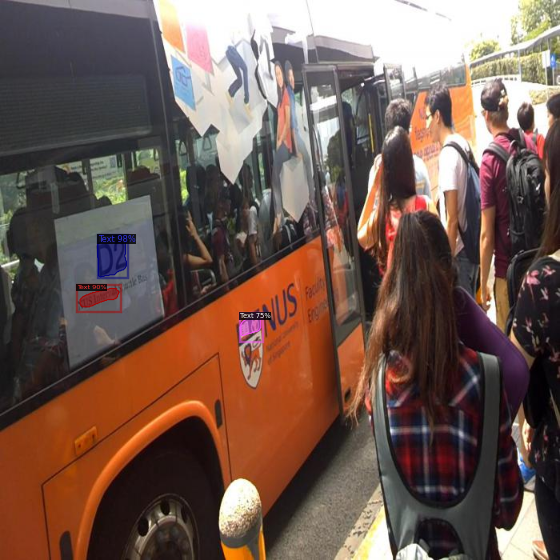

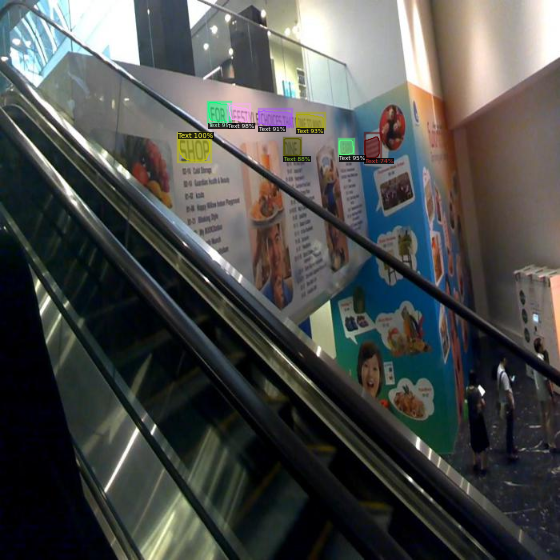

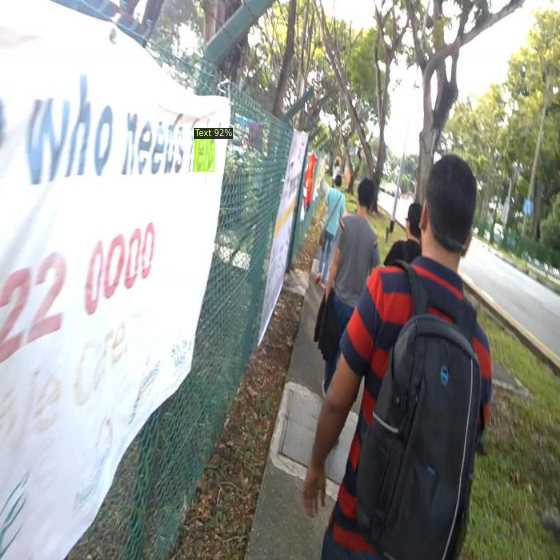

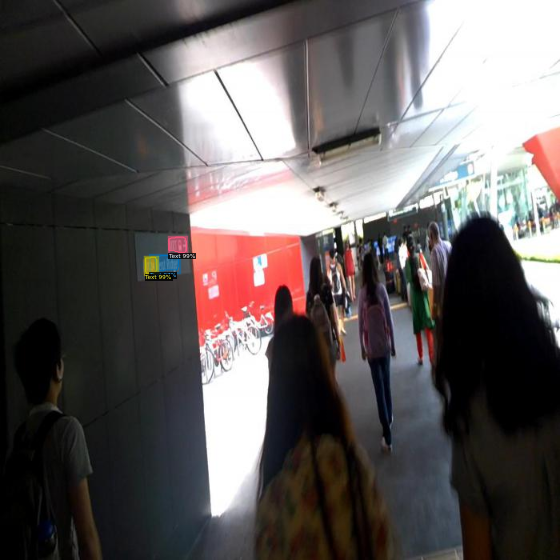

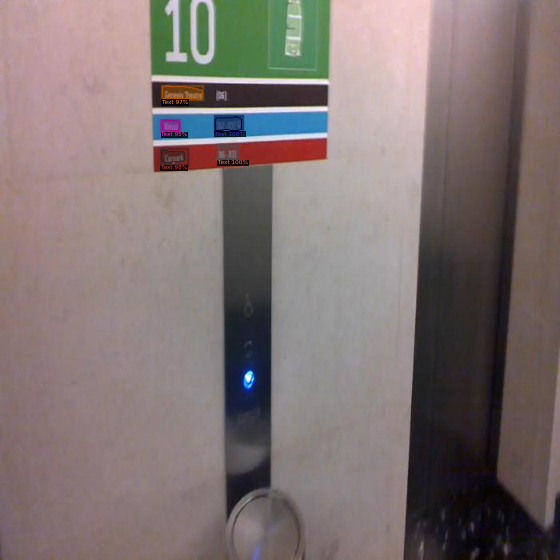

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])